In [81]:
%matplotlib inline

import pandas as pd
import numpy as np

from scipy.stats import t
from scipy.spatial.distance import pdist

from joblib import Parallel, delayed

import matplotlib.pyplot as plt

plt.rcParamsDefault['figure.figsize'] = plt.rcParams['figure.figsize'] = 25, 10
pd.options.display.max_rows = 16
pd.options.display.precision = 3

# Data preparation

In [39]:
# Pick yours
df = pd.read_csv('/tmp/netztest-opendata_hours-048.csv')
df = pd.read_csv('/tmp/netztest-opendata.csv')

In [89]:
# Select subsets of relevant features

X = df[['sim_mcc_mnc',
        'network_type',
        'model']]

y = df[['ping_ms',
        'download_kbit',
        'upload_kbit']]

In [90]:
# Purge values known to be irrelevant
X = X[~X.model.isin(['Firefox', 'Mozilla', 'Chrome', 'IE'])]
X = X[~X.network_type.isin(['WLAN', 'LAN', 'Bluetooth', 'Ethernet'])]

# Purge X values with less than N appearances
for col in X.columns:
    counts = X[col].value_counts()
    valid = ~X[col].isin(counts[counts < 50].index)
    X = X[valid]

# Prune y percentile outliers
for col in y.columns:
    vals = y[col]
    y = y[vals.between(*vals.quantile((.02, .98)))]

# Only keep what is contained in both sets
keep = X.index & y.index
X = X.loc[keep]
y = y.loc[keep]
df = df.loc[keep]

# Visualization

,sim_mcc_mnc,network_type,model
count,28737,28734,28738
unique,23,9,90
top,232-01,LTE,iPad mini 2G Cellular
freq,10734,23840,2803


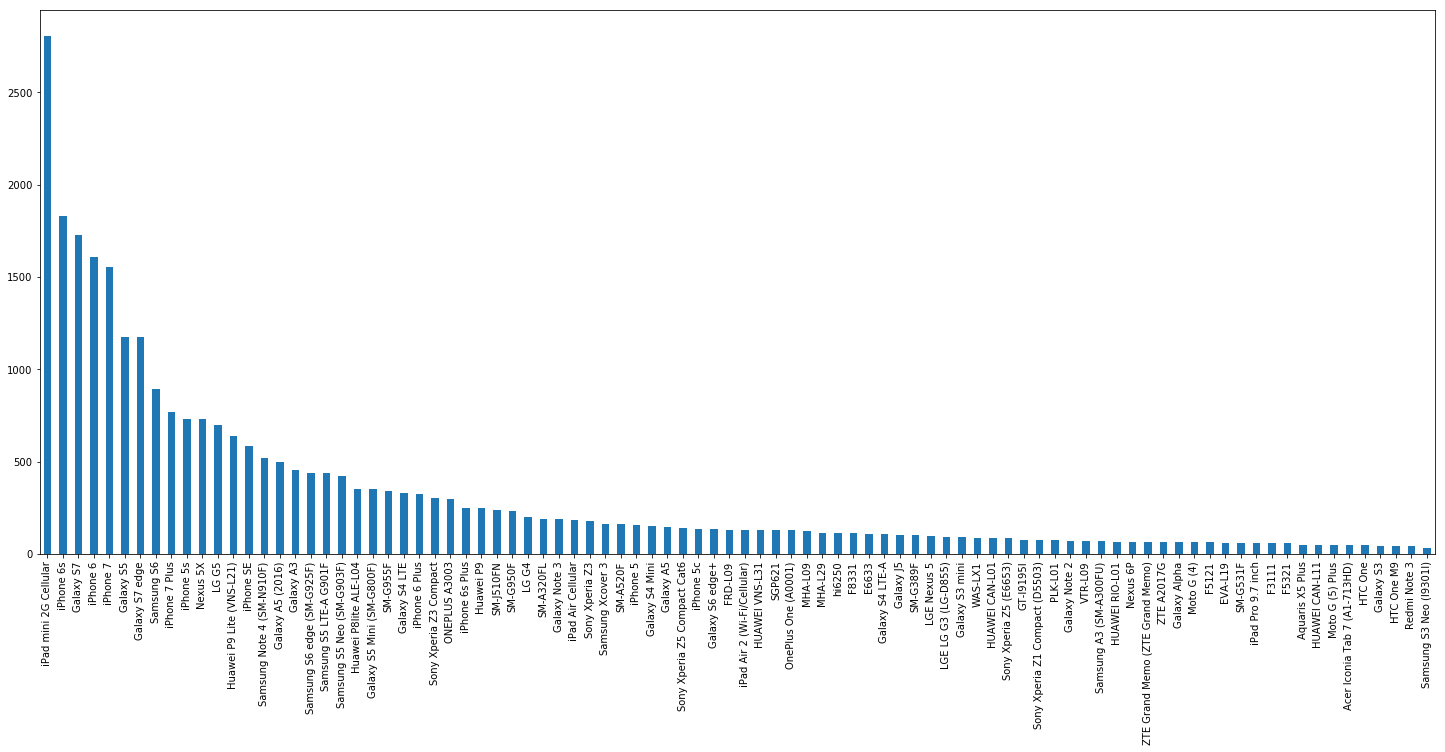

In [42]:
X.model.value_counts().plot.bar()
X.describe()

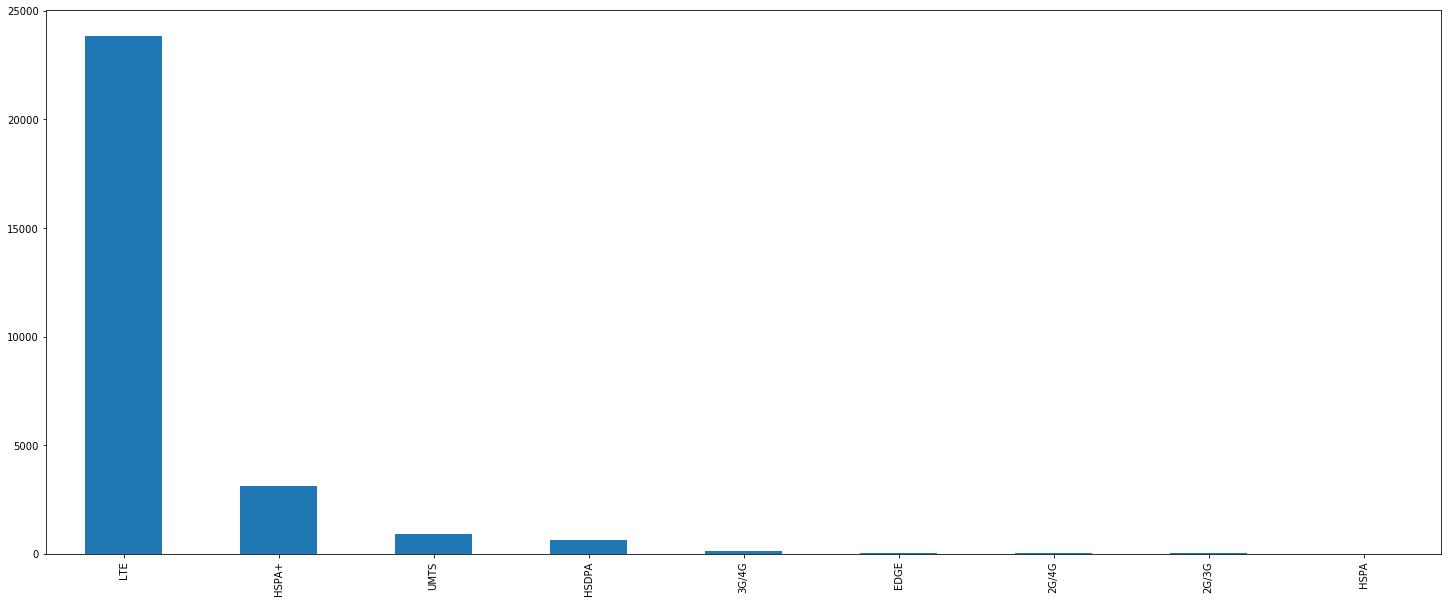

In [43]:
X.network_type.value_counts().plot.bar()

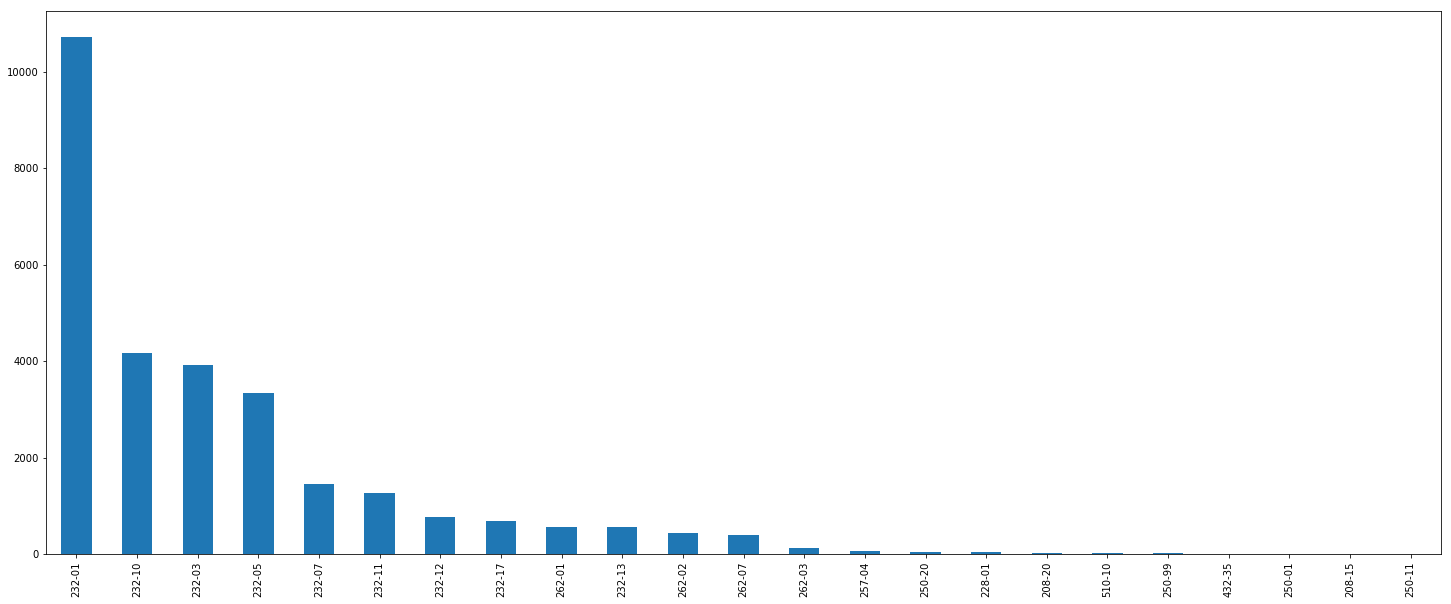

In [44]:
X.sim_mcc_mnc.value_counts().plot.bar()

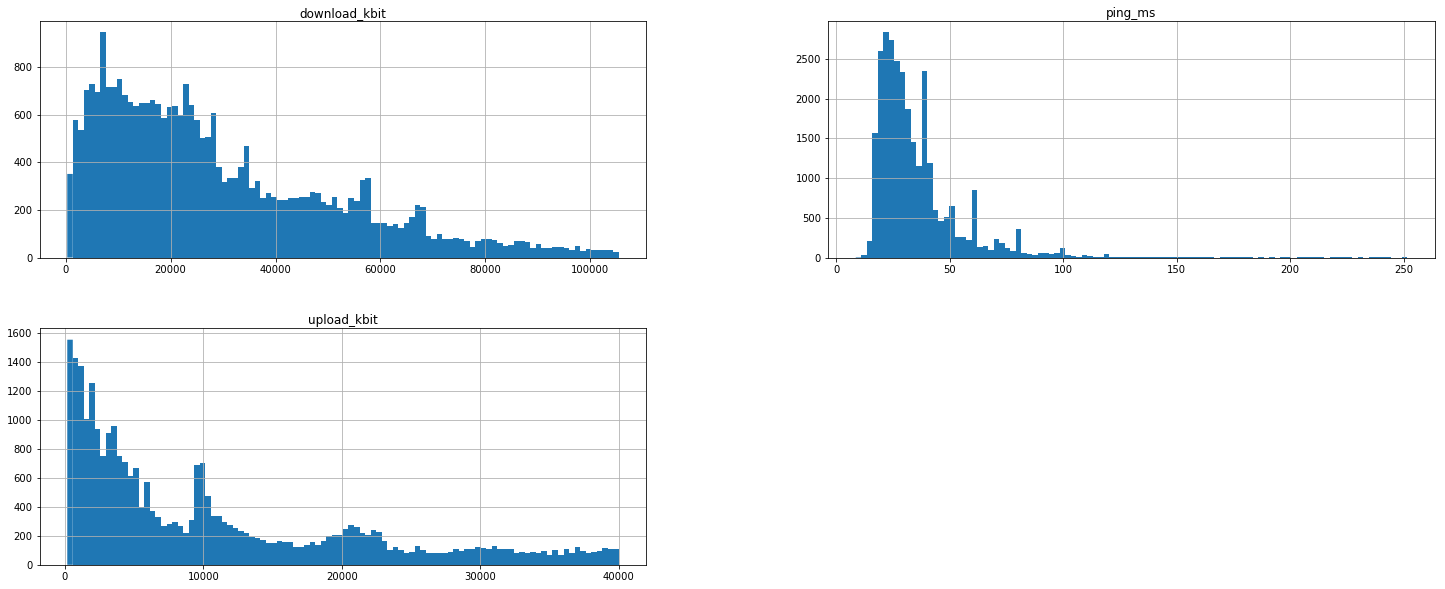

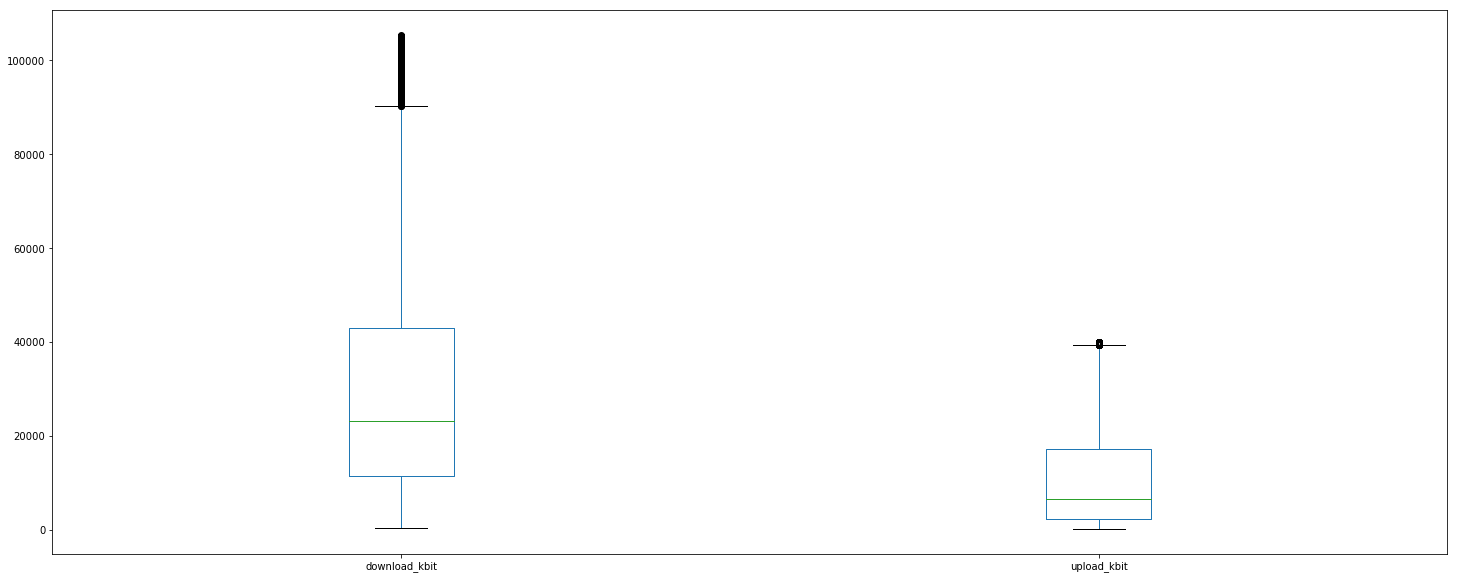

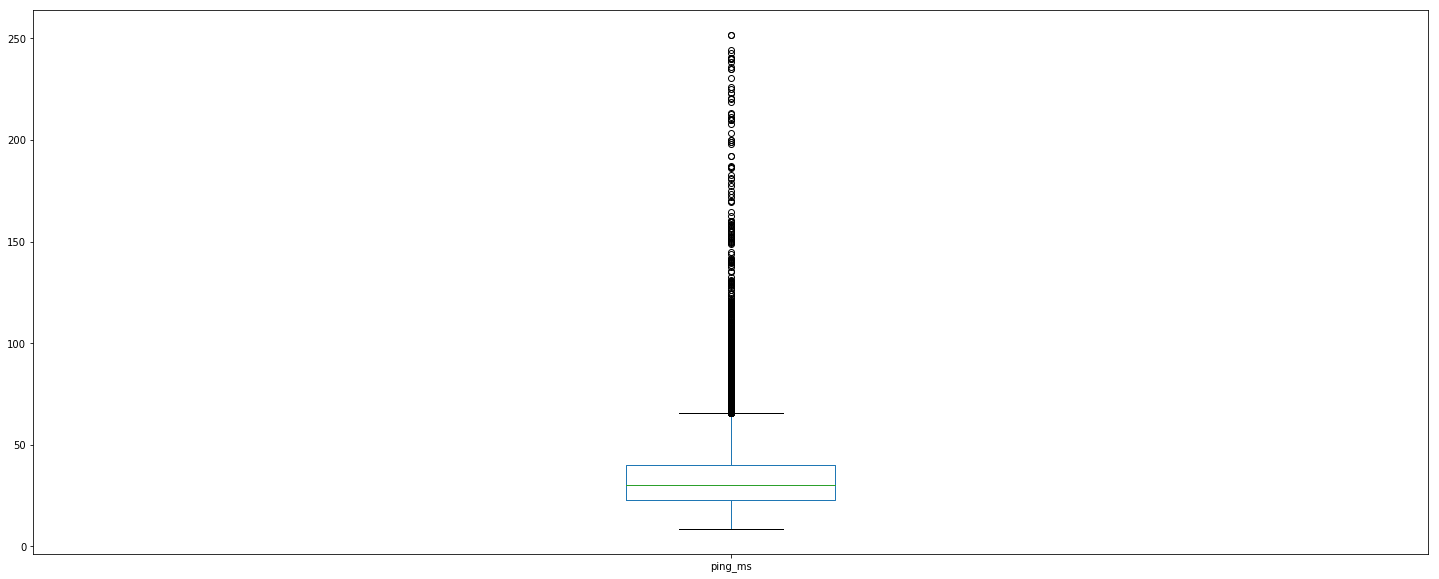

In [45]:
y.hist(bins=100)
y.filter(like='kbit').plot.box()
y.filter(like='ping').plot.box()
y.describe()
yorig = y.copy(False)

After preprocessing, not a significant difference in ping times between the two platforms. Probably not even statistically significant.

In [100]:
y.groupby(df.platform).describe(percentiles=[.5])

ping_ms                                    download_kbit             \
            count    mean     std   min   50%    max         count       mean   
platform                                                                        
Android   17617.0  34.725  19.566  10.9  29.6  251.6       17617.0  28886.256   
iOS       11121.0  36.245  18.469   8.5  30.5  199.2       11121.0  30337.989   

                                              upload_kbit             \
                std    min      50%       max       count       mean   
platform                                                               
Android   22820.050  325.0  23001.0  105243.0     17617.0  10796.051   
iOS       22411.102  333.0  23863.0  105379.0     11121.0  10878.521   

                                             
                std    min     50%      max  
platform                                     
Android   10471.357  166.0  6734.0  39994.0  
iOS       10701.730  166.0  6553.0  39992.0

# Testing for significance

In [144]:
def mean_pairwise_distance(X):
    return pdist(X).mean()

def p_value1(score, scores, *_):
    """Alternative: compute CDF directly"""
    return ((scores <= score).sum() + 1) / (scores.size + 1)

def p_value2(score, scores, dof, *_):
    """Alternative: assume scores are t-distributed"""
    return t.cdf(score, dof, loc=scores.mean(), scale=scores.std())

def score(y_sample):
    return np.median(y_sample.sum(1))

def ttest(X, key, y, *, n_repeats=1000, n_jobs=1, min_sample_size=50, exact_samples=False, f_score=score, f_pvalue=None):
    assert X.ndim == 2 and y.ndim == 2 and len(key)
    assert len(X.columns & key) == len(key)
    
    f_pvalue = f_pvalue or (p_value1 if min_sample_size >= 50 else p_value2)
    
    cache = {}
    y = (y - y.mean(0)) / y.std(0)  # Distances to be computed in normalized space
    parallel = Parallel(n_jobs=n_jobs, backend='threading')
    pvals, index = [], []
    
    for key_value, ids in X.groupby(list(key)).groups.items():    
        n = len(ids)
        if not exact_samples:
        # round to order of magnitude for more cache hits
            n = round(n, -int(np.log10(n)))
        
        if n < min_sample_size:
            continue
            
        distances = cache.get(n)
        if distances is None:
            print(n, end='.')
            cache[n] = distances = np.array(
                parallel(delayed(mean_pairwise_distance)(y.sample(n).values)
                         for _ in range(n_repeats)))
        else:
            print('.', end='')
                
        sample = y.loc[ids]
        sample_distance = mean_pairwise_distance(sample)
        pval = p_value1(sample_distance, distances, len(ids) - 1)
        sample_score = f_score(sample)
        
        pvals.append((len(ids), pval, sample_score))
        index.append(key_value)
    
    print()
    index = (index if len(key) == 1 else
             pd.MultiIndex.from_tuples(index, names=key))
    res = pd.DataFrame(pvals, index=index, columns=['n_inst', 'p_value', 'score']).round(3)
    res.sort_index(inplace=True)
    res.sort_values(by='score', inplace=True)
    return res

In [107]:
# Default score func just adds the dimensions together
# Higher ping is worse score, so revert ...
y.ping_ms = -yorig.ping_ms

In [111]:
%%time
# Platform plays insignificant role with respect to ping time
ttest(df[['platform']], ['platform'], y[['ping_ms']], n_repeats=100, exact_samples=True)

11121.17617.
CPU times: user 4min 17s, sys: 1min 3s, total: 5min 21s
Wall time: 5min 21s


,n_inst,p_value,score
iOS,11121,0.772,0.251
Android,17617,0.109,0.298


In [77]:
%%time
model_pvals = ttest(X, ['model'], y, n_jobs=-1)

3000.200.500.90.100..300.80.400.900.40.800..60.700...600...2000..70......30.50..1000...........................................................
CPU times: user 2min 30s, sys: 36.6 s, total: 3min 6s
Wall time: 55.8 s


In [78]:
model_pvals

,n_inst,p_value,score
Redmi Note 3,41,1.000,-5.517
Acer Iconia Tab 7 (A1-713HD),50,0.001,-5.207
ZTE Grand Memo (ZTE Grand Memo),65,0.001,-4.018
Galaxy Note 2,71,0.001,-3.481
Galaxy S3 mini,90,0.001,-2.974
Galaxy S3,45,0.001,-2.964
Samsung S3 Neo (I9301I),34,0.001,-2.049
VTR-L09,70,0.991,-1.958
...,...,...,...
Huawei P9,246,0.178,0.237


,n_inst,p_value,score
count,90.000,90.000,90.000
mean,319.311,0.222,-0.640
std,467.103,0.337,1.212
min,34.000,0.001,-5.517
25%,70.250,0.001,-0.902
50%,131.000,0.009,-0.462
75%,337.000,0.300,-0.062
max,2803.000,1.000,2.634


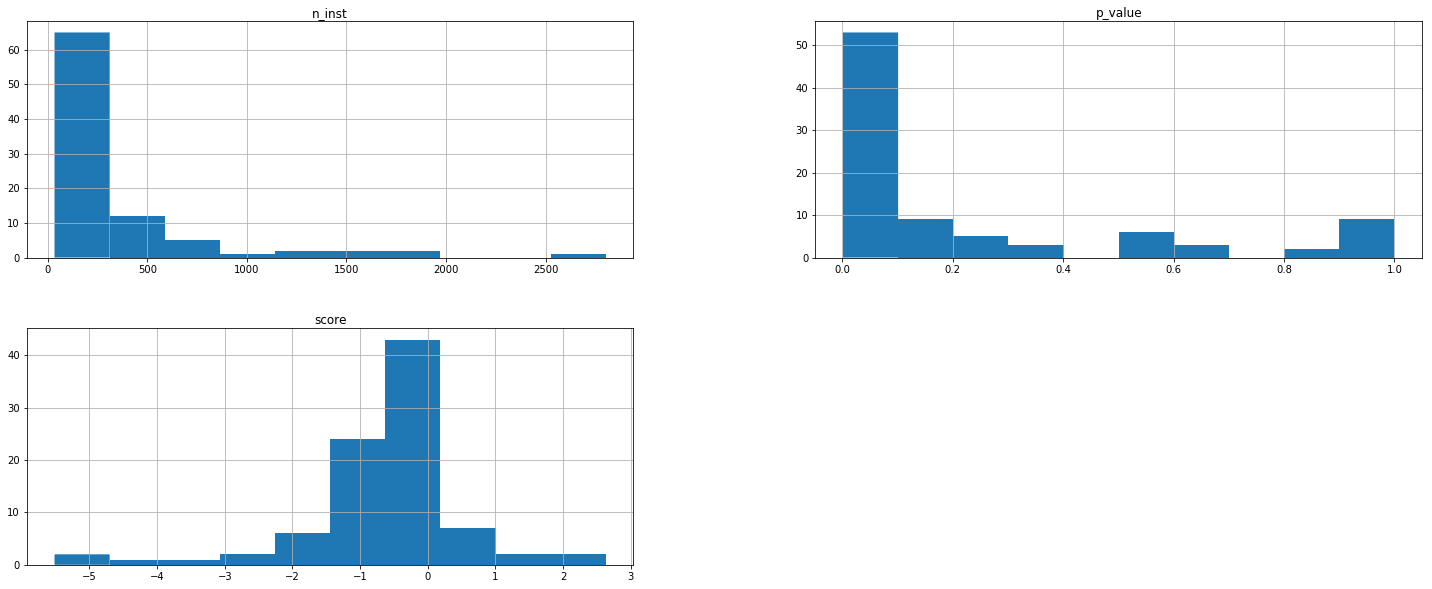

In [79]:
model_pvals.hist()
model_pvals.describe()

In [112]:
%%time
network_type_pvals = ttest(X, ['network_type'], y, n_jobs=5)

600.900.20000.3000.100.
CPU times: user 37min 29s, sys: 12min 5s, total: 49min 34s
Wall time: 11min 29s


In [113]:
network_type_pvals

,n_inst,p_value,score
HSDPA,639,0.001,-2.462
HSPA+,3139,0.001,-2.052
3G/4G,113,0.001,-1.685
UMTS,912,0.001,-1.448
LTE,23840,0.260,0.200


In [114]:
network_type_pvals.describe()

,n_inst,p_value,score
count,5.000,5.000,5.000
mean,5728.600,0.053,-1.489
std,10190.283,0.116,1.019
min,113.000,0.001,-2.462
25%,639.000,0.001,-2.052
50%,912.000,0.001,-1.685
75%,3139.000,0.001,-1.448
max,23840.000,0.260,0.200


In [115]:
%%time
sim_mcc_mnc_pvals = ttest(X, ['sim_mcc_mnc'], y, n_jobs=5)

600.4000..50.70.10000.700.1000.500...800.400.3000.100.
CPU times: user 9min 6s, sys: 3min 8s, total: 12min 14s
Wall time: 3min 4s


In [116]:
sim_mcc_mnc_pvals

,n_inst,p_value,score
250-20,50,0.001,-5.207
257-04,66,0.001,-4.051
262-07,390,0.001,-2.650
232-13,566,0.007,-2.313
262-03,138,0.001,-2.262
262-02,451,0.001,-1.998
262-01,567,0.095,-1.403
232-07,1460,0.001,-0.954
232-10,4169,0.001,-0.486
232-05,3352,0.003,-0.160


,n_inst,p_value,score
count,15.000,15.000,15.000
mean,1906.267,0.072,-1.364
std,2810.395,0.247,1.704
min,50.000,0.001,-5.207
25%,420.500,0.001,-2.288
50%,689.000,0.001,-0.954
75%,2406.000,0.002,-0.011
max,10734.000,0.960,0.516


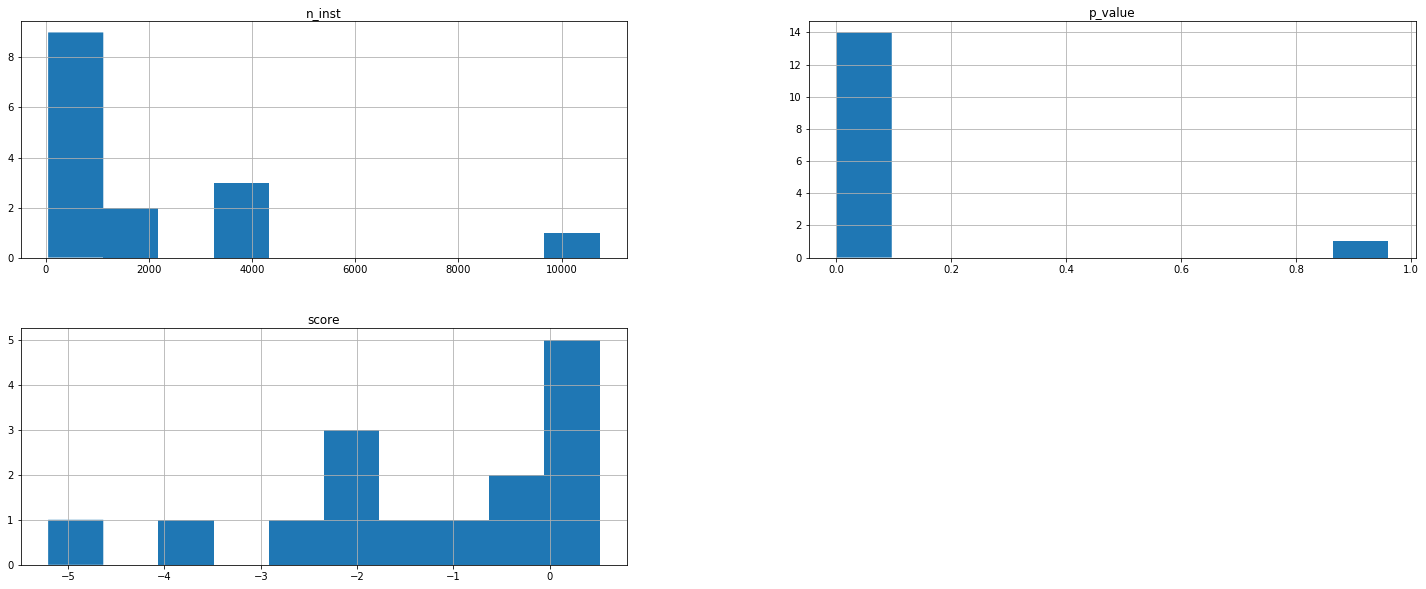

In [117]:
sim_mcc_mnc_pvals.hist()
sim_mcc_mnc_pvals.describe()

In [135]:
%%time
model_network_type_pvals = ttest(X, ['network_type', 'model'], y, n_jobs=-1)

400.800.200.80.100.50.60.............2000.300.............1000.90...........3000.70.......500...700........................................600.................
CPU times: user 1min 34s, sys: 24.6 s, total: 1min 59s
Wall time: 34.2 s


In [136]:
model_network_type_pvals.query('network_type == "LTE" and p_value <= .002')

n_inst  p_value  score
network_type model                                           
LTE          Galaxy S4 LTE                215    0.001 -0.901
             Sony Xperia Z3               167    0.001 -0.847
             E6633                        100    0.001 -0.550
             Moto G (5) Plus               49    0.001 -0.520
             HUAWEI CAN-L01                81    0.001 -0.477
             Samsung A3 (SM-A300FU)        54    0.001 -0.320
             Galaxy A5                    100    0.002 -0.307
             iPhone SE                    493    0.001 -0.259
...                                       ...      ...    ...
             Sony Xperia Z5 (E6653)        68    0.001  0.166
             iPhone 5c                    111    0.002  0.200
             Huawei P9 Lite (VNS-L21)     546    0.001  0.348
             Nexus 5X                     636    0.001  0.354
             Galaxy J5                     78    0.001  0.406
             hi6250                       111    0.001  1.556
             LG G5                        682    0.001  2.471
             Samsung S5 LTE-A G901F       412    0.001  2.779

[27 rows x 3 columns]

,n_inst,p_value,score
count,113.000,113.000,113.000
mean,240.761,0.160,-0.618
std,371.499,0.286,1.268
min,46.000,0.001,-5.207
25%,64.000,0.001,-1.529
50%,107.000,0.002,-0.218
75%,225.000,0.201,0.177
max,2616.000,1.000,2.779


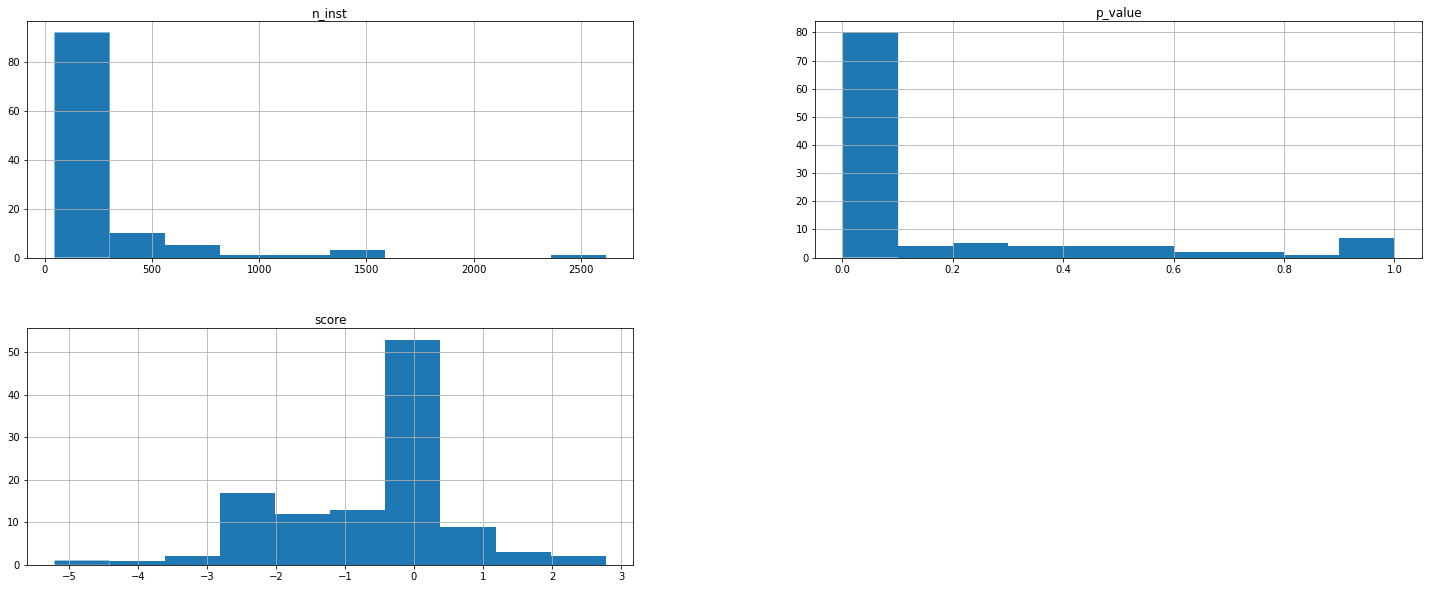

In [137]:
model_network_type_pvals.hist()
model_network_type_pvals.describe()

In [138]:
%%time
model_sim_mcc_mnc_pvals = ttest(X, ['sim_mcc_mnc', 'model'], y, n_jobs=-1)

100..3000.90.80.200.300.50.....60...600....70.......500.........800.400................................700......................................................
CPU times: user 1min 8s, sys: 16.6 s, total: 1min 25s
Wall time: 26.6 s


In [139]:
model_sim_mcc_mnc_pvals.query('p_value <= .002')

n_inst  p_value  score
sim_mcc_mnc model                                                  
250-20      Acer Iconia Tab 7 (A1-713HD)         50    0.001 -5.207
257-04      ZTE Grand Memo (ZTE Grand Memo)      65    0.001 -4.018
232-11      Galaxy S3 mini                       69    0.001 -2.983
262-07      Galaxy S7                            46    0.001 -2.935
            Galaxy S7 edge                       47    0.001 -2.648
262-01      Galaxy S4 LTE-A                      59    0.001 -2.470
232-07      iPhone 5s                            53    0.001 -1.961
232-10      Galaxy S4 LTE                       191    0.001 -1.932
...                                             ...      ...    ...
232-12      iPhone 5s                            46    0.001  0.147
232-03      iPhone 6                            363    0.001  0.195
            Galaxy S7 edge                      146    0.002  0.251
232-11      iPhone 6                             61    0.001  0.434
232-05      hi6250                              112    0.001  1.554
232-11      Nexus 5X                             73    0.001  1.565
232-03      LG G5                               639    0.001  2.534
            Samsung S5 LTE-A G901F              388    0.001  2.861

[57 rows x 3 columns]

,n_inst,p_value,score
count,122.000,122.000,122.000
mean,168.754,0.183,-0.195
std,277.997,0.308,1.197
min,46.000,0.001,-5.207
25%,58.250,0.001,-0.869
50%,87.000,0.003,-0.071
75%,175.750,0.247,0.345
max,2782.000,0.997,2.861


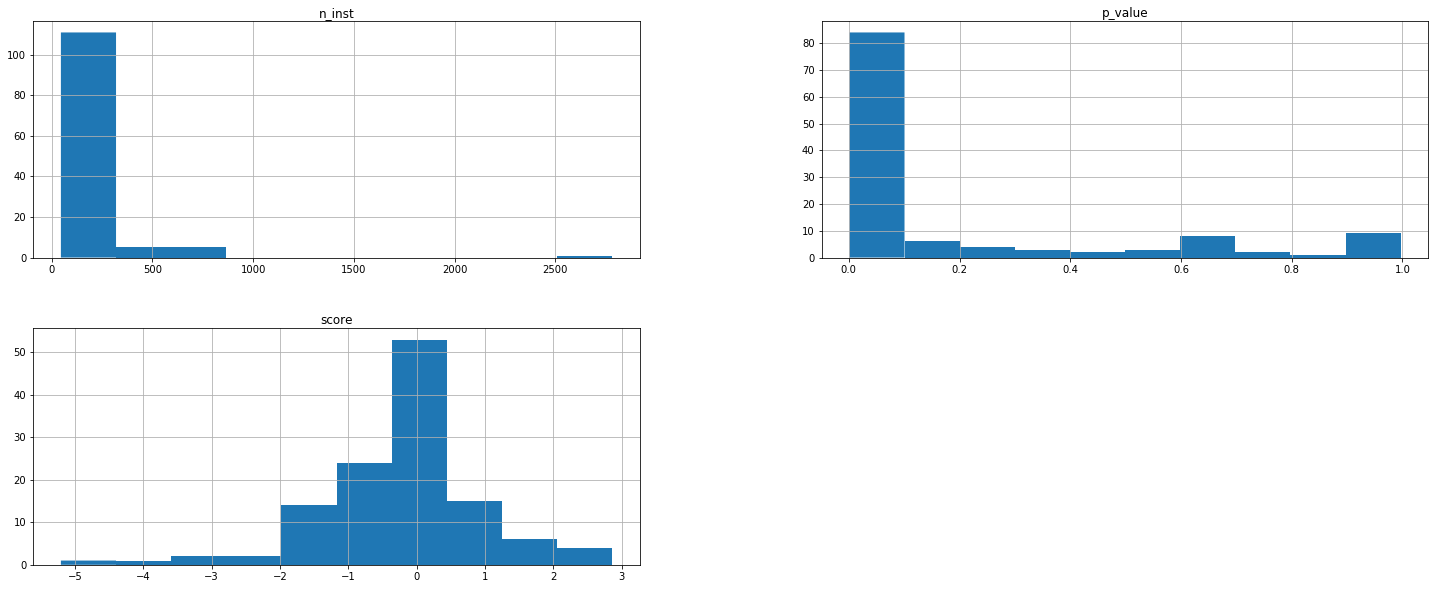

In [140]:
model_sim_mcc_mnc_pvals.hist()
model_sim_mcc_mnc_pvals.describe()

In [124]:
%%time
network_type_model_sim_mcc_mnc_pvals = ttest(X, ['network_type', 'sim_mcc_mnc', 'model'], y, n_jobs=-1)

200.100.300..70..50.700.80....60.......90.....400....................................600.....3000...........................500.....................
CPU times: user 1min 4s, sys: 16.2 s, total: 1min 20s
Wall time: 25 s


In [125]:
network_type_model_sim_mcc_mnc_pvals

n_inst  p_value  \
network_type sim_mcc_mnc model                                              
HSPA+        250-20      Acer Iconia Tab 7 (A1-713HD)         50    0.001   
             257-04      ZTE Grand Memo (ZTE Grand Memo)      64    0.001   
HSDPA        232-11      Galaxy S3 mini                       68    0.001   
HSPA+        262-01      Galaxy S4 LTE-A                      47    0.001   
             232-10      Galaxy S4 LTE                        91    0.001   
                         Nexus 5X                             63    0.001   
HSDPA        232-10      iPhone 6                             65    0.001   
LTE          232-10      SM-J510FN                            91    0.584   
...                                                          ...      ...   
             232-05      hi6250                              109    0.001   
             232-11      Nexus 5X                             66    0.001   
             232-17      Galaxy A5 (2016)                     54    0.967   
             232-11      Galaxy S5                            76    0.008   
             232-03      LG G5                               639    0.001   
                         Samsung Note 4 (SM-N910F)           122    0.317   
             262-01      iPhone 6s                            49    0.940   
             232-03      Samsung S5 LTE-A G901F              375    0.001   

                                                          score  
network_type sim_mcc_mnc model                                   
HSPA+        250-20      Acer Iconia Tab 7 (A1-713HD)    -5.207  
             257-04      ZTE Grand Memo (ZTE Grand Memo) -4.051  
HSDPA        232-11      Galaxy S3 mini                  -2.981  
HSPA+        262-01      Galaxy S4 LTE-A                 -2.564  
             232-10      Galaxy S4 LTE                   -2.317  
                         Nexus 5X                        -2.169  
HSDPA        232-10      iPhone 6                        -1.930  
LTE          232-10      SM-J510FN                       -1.505  
...                                                         ...  
             232-05      hi6250                           1.577  
             232-11      Nexus 5X                         1.585  
             232-17      Galaxy A5 (2016)                 1.776  
             232-11      Galaxy S5                        2.006  
             232-03      LG G5                            2.534  
                         Samsung Note 4 (SM-N910F)        2.704  
             262-01      iPhone 6s                        2.706  
             232-03      Samsung S5 LTE-A G901F           2.912  

[113 rows x 3 columns]

,n_inst,p_value,score
count,113.000,113.000,113.000
mean,161.973,0.169,0.048
std,261.731,0.305,1.246
min,46.000,0.001,-5.207
25%,63.000,0.001,-0.565
50%,98.000,0.003,0.202
75%,168.000,0.196,0.671
max,2598.000,1.000,2.912


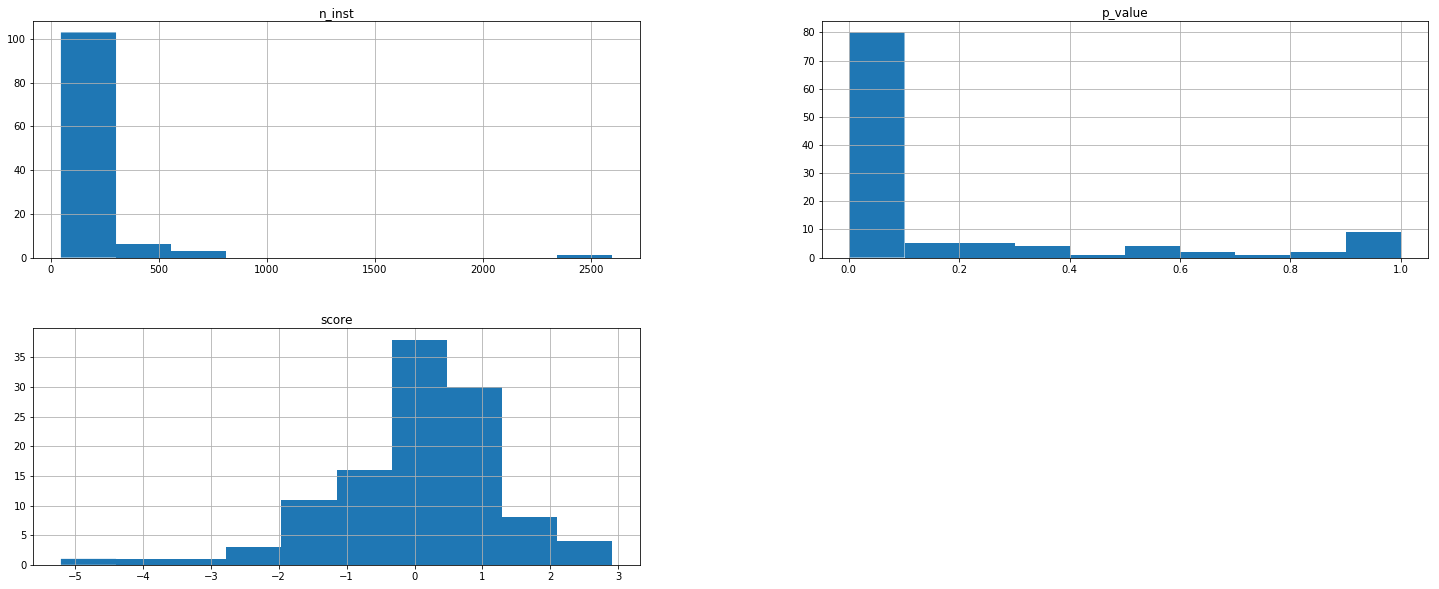

In [126]:
network_type_model_sim_mcc_mnc_pvals.hist()
network_type_model_sim_mcc_mnc_pvals.describe()

In [134]:
network_type_model_sim_mcc_mnc_pvals.query('network_type == "LTE" and p_value < .002')

n_inst  p_value  score
network_type sim_mcc_mnc model                                             
LTE          232-03      iPhone SE                      107    0.001 -1.218
                         Galaxy S5                       66    0.001 -1.195
             232-07      Galaxy S7                       55    0.001 -1.185
             232-11      Sony Xperia Z3                  78    0.001 -1.155
             232-10      Galaxy S4 LTE                  100    0.001 -1.140
             232-07      Galaxy A3                       49    0.001 -1.071
             232-03      Samsung S6 edge (SM-G925F)      80    0.001 -1.047
             232-07      Samsung S5 Neo (SM-G903F)       51    0.001 -0.938
...                                                     ...      ...    ...
             232-03      iPhone 6                       345    0.001  0.372
                         Galaxy S7                      164    0.001  0.556
             232-05      iPhone 6                       167    0.001  0.615
             232-10      Galaxy S5 Mini (SM-G800F)       46    0.001  0.671
             232-05      hi6250                         109    0.001  1.577
             232-11      Nexus 5X                        66    0.001  1.585
             232-03      LG G5                          639    0.001  2.534
                         Samsung S5 LTE-A G901F         375    0.001  2.912

[35 rows x 3 columns]

In [141]:
%%time
network_type_sim_mcc_mnc_pvals = ttest(X, ['network_type', 'sim_mcc_mnc'], y, n_jobs=-1)

60.200..400.600.....1000.70.100.3000.50.500.................9000....4000.
CPU times: user 9min 14s, sys: 2min 49s, total: 12min 3s
Wall time: 2min 10s


In [142]:
network_type_sim_mcc_mnc_pvals.query('p_value <= .002')

n_inst  p_value  score
network_type sim_mcc_mnc                        
HSPA+        232-13           58    0.001 -5.434
             250-20           50    0.001 -5.207
             257-04           65    0.001 -4.084
             262-07          168    0.001 -3.181
HSDPA        232-11           68    0.001 -2.981
HSPA+        262-01          114    0.001 -2.620
             262-02          169    0.001 -2.538
UMTS         232-03           63    0.001 -2.466
...                          ...      ...    ...
             232-12           50    0.001 -1.122
LTE          232-07         1196    0.001 -0.589
             232-10         3352    0.001  0.097
             232-05         2791    0.001  0.311
             232-01         9044    0.001  0.314
             232-03         3703    0.001  0.567
             232-12          601    0.001  0.610
             232-11         1003    0.001  0.975

[33 rows x 3 columns]

,n_inst,p_value,score
count,36.000,36.000,36.000
mean,783.472,0.041,-1.660
std,1674.738,0.177,1.499
min,50.000,0.001,-5.434
25%,68.750,0.001,-2.242
50%,173.000,0.001,-1.773
75%,607.250,0.001,-0.927
max,9044.000,0.950,0.975


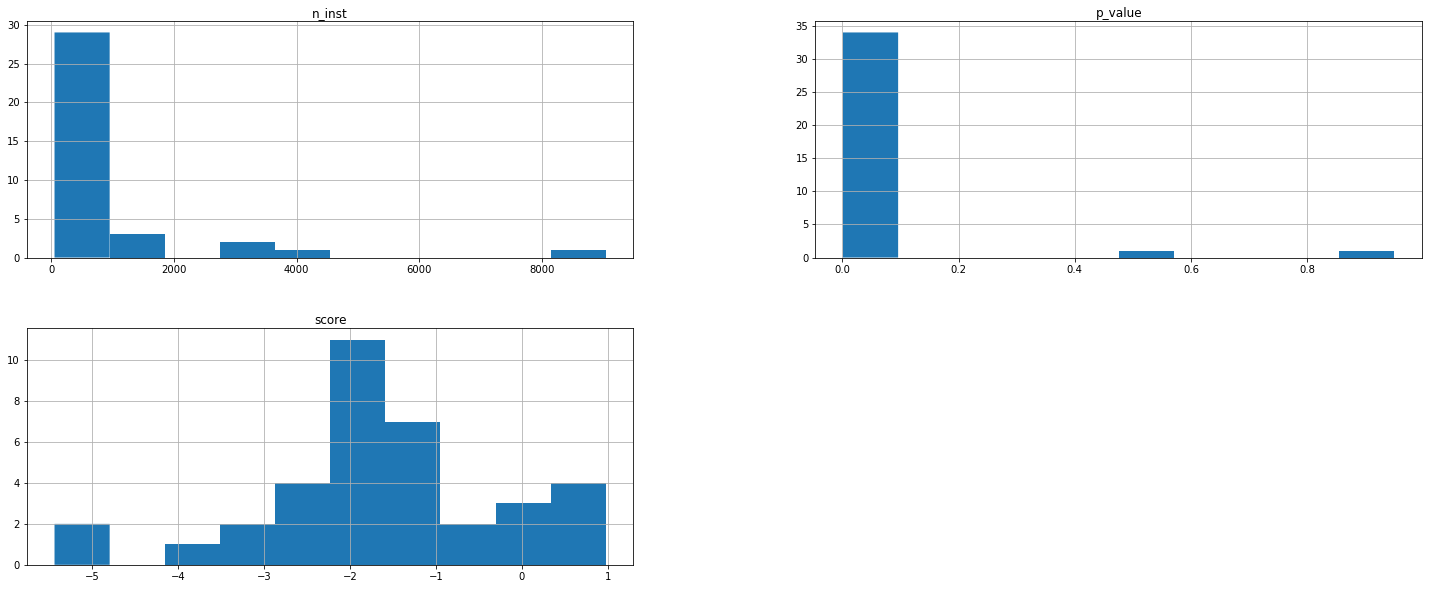

In [143]:
network_type_sim_mcc_mnc_pvals.hist()
network_type_sim_mcc_mnc_pvals.describe()

In [ ]:
...